# Predicting the Sale Price of bulldozers using of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem Definition

> How well can we predict the future sale price of a bulldozer, given it's characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for bulldozers competion:

There are 3 main datasets:
- Train.csv is the training set, which contains data through the end of 2011.
- Valid.csv is the validation set, which contains data from January 1, 2012 April 30, 2012 You make predictions on this se throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation
The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

for more on the evaluation of this project check:
https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimizes the RMSE.

## 4. Features
Kaggle provides a data dictionary detailing all the feaures of the dataset. You can view this data dictionary on Google Sheets:
[Data Dictionary]('https://docs.google.com/spreadsheets/d/1NhEW_p1GCM3KtfmpO40WFDvAaObG3oiO/edit?usp=sharing&ouid=108077637651180024837&rtpof=true&sd=true')

In [55]:
# Import Statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scaling, Model & Evaluation metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

In [2]:
# Read the training set
df = pd.read_csv('Data/Train.csv', low_memory=False)
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.shape

(401125, 53)

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    258360
UsageBand                   331486
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             137191
fiModelSeries               344217
fiModelDescriptor           329206
ProductSize                 210775
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                296764
Enclosure                      325
Forks                       209048
Pad_Type                    321991
Ride_Control                252519
Stick                       321991
Transmission                217895
Turbocharged                321991
Blade_Extension     

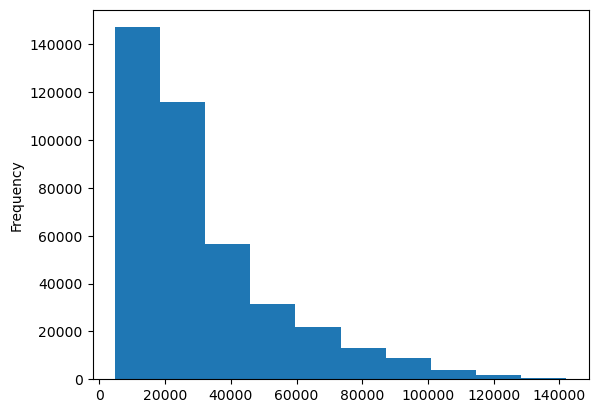

In [5]:
df.SalePrice.plot.hist();

### Parsing Dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the parse_dates parameter.


In [6]:
# Import data again but this time parse time
df = pd.read_csv('Data/TrainAndValid.csv', low_memory=False, parse_dates=['saledate'])
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.saledate.dtype

dtype('<M8[ns]')

In [8]:
df.saledate.head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

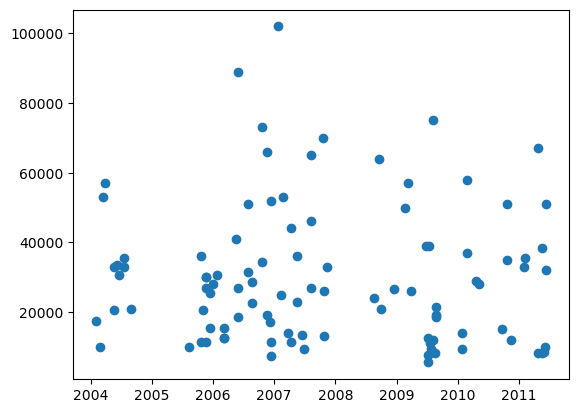

In [9]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:100], df['SalePrice'][:100])
plt.show()

### Make a copy of the original DataFrame

In [10]:
df_copy = df.sort_values(by=['saledate'], ascending=True)
df_copy.saledate.head(15)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [11]:
df.sort_values(by=['saledate'], inplace=True, ascending=True)
df.saledate.head(10)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
Name: saledate, dtype: datetime64[ns]

### Add datetime parameters for `saledate` column

In [12]:
df_copy['saleYear'] = df_copy['saledate'].dt.year
df_copy['saleMonth'] = df_copy['saledate'].dt.month
df_copy['saleDay'] = df_copy['saledate'].dt.date
df_copy['saleDayOfWeek'] = df_copy['saledate'].dt.dayofweek
df_copy['saleDayOfYear'] = df_copy['saledate'].dt.dayofyear

In [13]:
df_copy.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [14]:
df_copy.drop('saledate', axis=1, inplace=True)

In [15]:
# Method to check whether a column is an obj/str type
pd.api.types.is_string_dtype(df_copy['UsageBand'])

True

In [16]:
# Find the columns which contain strings
str_cols = []
for label, content in df_copy.items():
    if pd.api.types.is_string_dtype(content):
        str_cols.append(label)
str_cols

['UsageBand',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls',
 'saleDay']

In [17]:
# Labels -> Column names, Content -> Values in the columns
# This will turn all of the string columns into category values
for label, content in df_copy.items():
    if pd.api.types.is_string_dtype(content):
        df_copy[label] = content.astype('category').cat.as_ordered()
        
df_copy.dtypes

SalesID                        int64
SalePrice                    float64
MachineID                      int64
ModelID                        int64
datasource                     int64
auctioneerID                 float64
YearMade                       int64
MachineHoursCurrentMeter     float64
UsageBand                   category
fiModelDesc                 category
fiBaseModel                 category
fiSecondaryDesc             category
fiModelSeries               category
fiModelDescriptor           category
ProductSize                 category
fiProductClassDesc          category
state                       category
ProductGroup                category
ProductGroupDesc            category
Drive_System                category
Enclosure                   category
Forks                       category
Pad_Type                    category
Ride_Control                category
Stick                       category
Transmission                category
Turbocharged                category
B

In [18]:
df_copy.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [19]:
df_copy.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

>Thanks to pandas Categories we now have a way to access all of our data in the form of numbers.

In [20]:
nan = dict(df.isna().sum()/len(df))
dicts = {}
for label, value in nan.items():
    if value > 0:
        dicts[label] = value
        
pd.Series(dicts)

auctioneerID                0.048791
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
Blade_Extension             0.937041
Blade_Width                 0.937041
Enclosure_Type              0.937041
Engine_Horsepower           0.937041
Hydraulics                  0.200062
Pushblock                   0.937041
Ripper                      0.740864
Scarifier                   0.937014
Tip_Control                 0.937041
Tire_Size                   0.763415
Coupler                     0.465277
Coupler_System              0.891024
G

### Fill Missing Values

In [21]:
# Numeric Columns
for label, content in df_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDayOfWeek
saleDayOfYear


In [22]:
# Check for which numeric columns contain NaNs
for label, content in df_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [23]:
# Fill numeric rows with median
for label, content in df_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing
            df_copy[label + '_is_missing'] = pd.isnull(content)
            # Fill missing numeric values with median
            df_copy[label] = content.fillna(content.median())
            # For large data median is more robust than mean

In [24]:
for label, content in df_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label) 

In [25]:
nan = dict(df_copy.isna().sum()/len(df_copy))
dicts = {}
for label, value in nan.items():
    if value > 0:
        dicts[label] = value
        
pd.Series(dicts)

UsageBand                  0.821492
fiSecondaryDesc            0.340993
fiModelSeries              0.857845
fiModelDescriptor          0.818715
ProductSize                0.524851
Drive_System               0.740520
Enclosure                  0.000809
Forks                      0.520921
Pad_Type                   0.803498
Ride_Control               0.629928
Stick                      0.803498
Transmission               0.544444
Turbocharged               0.803498
Blade_Extension            0.937041
Blade_Width                0.937041
Enclosure_Type             0.937041
Engine_Horsepower          0.937041
Hydraulics                 0.200062
Pushblock                  0.937041
Ripper                     0.740864
Scarifier                  0.937014
Tip_Control                0.937041
Tire_Size                  0.763415
Coupler                    0.465277
Coupler_System             0.891024
Grouser_Tracks             0.891264
Hydraulics_Flow            0.891264
Track_Type                 0

In [26]:
df_copy.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [27]:
df_copy.MachineHoursCurrentMeter_is_missing.value_counts()

True     265194
False    147504
Name: MachineHoursCurrentMeter_is_missing, dtype: int64

### Filling and turning categorical variables into numbers

In [28]:
pd.Categorical(df_copy['state']).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [29]:
# Turn categorical variables into numbers and fill missing values
for label, content in df_copy.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_copy[label + '_is_missing'] = pd.isnull(content)
        # Turn categorical into numbers and add + 1
        df_copy[label] = pd.Categorical(content).codes+1

In [30]:
df_copy.head(10)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,saleDay_is_missing
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,False,False,False,True,True,False
274835,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,False,False,False
141296,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,False,False,False,True,True,False
212552,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,False,False,False
62755,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,False,False,False,True,True,False
54653,1301884,23500.0,1182999,4123,132,99.0,1976,0.0,0,2298,...,True,True,True,True,False,False,False,True,True,False
81383,1379228,31000.0,1082797,7620,132,99.0,1986,0.0,0,3126,...,True,True,True,True,True,True,True,False,False,False
204924,1645390,11750.0,1527216,8202,132,99.0,1970,0.0,0,979,...,True,True,True,True,True,True,True,False,False,False
135376,1493279,63000.0,1363756,2759,132,99.0,1987,0.0,0,2224,...,True,True,True,True,False,False,False,True,True,False
113390,1449549,13000.0,1289412,3356,132,99.0,1966,0.0,0,82,...,True,True,True,True,True,True,True,True,True,False


# 5. Modelling

In [31]:
%%time
# Let's build a machine learning model
x = df_copy.drop('SalePrice', axis=1)
y = df_copy['SalePrice']

# Instantiate the model
model = RandomForestRegressor(n_jobs=-1, random_state=42)

# Fit the model
model.fit(x, y)

Wall time: 6min 10s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [32]:
model.score(x, y)

0.9878818383922341

### Splitting data into train and validation sets

In [33]:
df_copy.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [34]:
# Split data into train and validation set
df_val = df_copy[df_copy.saleYear == 2012]
df_train = df_copy[df_copy.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [35]:
# Split data into X & y
x_tr, y_tr = df_train.drop('SalePrice', axis=1), df_train.SalePrice
x_val, y_val = df_val.drop('SalePrice', axis=1), df_val.SalePrice

x_tr.shape, y_tr.shape, x_val.shape, y_val.shape

((401125, 103), (401125,), (11573, 103), (11573,))

In [53]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, r2_score

def rmsle(y_tst, y_preds):
    '''
    Calculates root mean squared log error between predictions and true labels.
    '''
    return np.sqrt(mean_squared_log_error(y_tst, y_preds))

# Create function to evaluate model on a few different levels
def evaluate(model, x_tr, x_val, y_tr, y_val):
    train_preds = model.predict(x_tr)
    val_preds = model.predict(x_val)
    scores = {
        'Training MAE': mean_absolute_error(y_tr, train_preds), 
        'Valid MAE': mean_absolute_error(y_val, val_preds),
        'Training RMSLE': rmsle(y_tr, train_preds),
        'Valid RMSLE': rmsle(y_val, val_preds),
        'Train R2 Score': r2_score(y_tr, train_preds),
        'Valid R2 Score': r2_score(y_val, val_preds)
    }
    return scores

## Testing out model on a subset (to tune the hyperparameters)
**This takes a lot of time to run**


In [42]:
# model = RandomForestRegressor(n_jobs=-1, random_state=42)

In [43]:
%%time
# Change max_samples value to avoid the time consumption
model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)
model.fit(x_tr, y_tr)

Wall time: 13.2 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [54]:
evaluate(model, x_tr, x_val, y_tr, y_val)

{'Training MAE': 5426.020265004678,
 'Valid MAE': 7229.919249114318,
 'Training RMSLE': 0.2536628970583116,
 'Valid RMSLE': 0.2979486517023542,
 'Train R2 Score': 0.8659493856089512,
 'Valid R2 Score': 0.8320465124503685}

# RandomizedSeachCV()

In [57]:
%%time
grid = {
    'n_estimators': np.linspace(100, 1500, 15, dtype=int),
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': np.arange(2, 20, 2),
    'max_features': [0.5, 1, 'sqrt', 'auto'],
    'max_samples': [10000]
}

# Instantiate RandomizedSearchCV Model
rsv = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42), 
                         param_distributions=grid, n_iter=5, cv=5, verbose=True)

# Fit the model
rsv.fit(x_tr, y_tr)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Wall time: 8min 28s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500])},
                   verbose=True)

In [58]:
rsv.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'max_samples': 10000,
 'max_features': 1,
 'max_depth': None}

In [59]:
evaluate(rsv, x_tr, x_val, y_tr, y_val)

{'Training MAE': 7731.893233132215,
 'Valid MAE': 10523.490389700164,
 'Training RMSLE': 0.3489069444879165,
 'Valid RMSLE': 0.42671659077126173,
 'Train R2 Score': 0.7520567147407988,
 'Valid R2 Score': 0.6867522531440804}

### Train a model with the best hyperparameters

**Note**: For n_iter = 100, after running for 2 hours the best parameters are 

In [61]:
%%time
# Ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40, min_samples_leaf=1, min_samples_split=14, 
                                    max_features=0.5, n_jobs=-1, max_samples=None)
# Fit the ideal model
ideal_model.fit(x_tr, y_tr)

Wall time: 56.1 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1)

In [62]:
# Evaluation of Ideal Model
evaluate(ideal_model, x_tr, x_val, y_tr, y_val)

{'Training MAE': 2878.994661772055,
 'Valid MAE': 6029.400552926289,
 'Training RMSLE': 0.14190208696757015,
 'Valid RMSLE': 0.250153012131817,
 'Train R2 Score': 0.9607410520290138,
 'Valid R2 Score': 0.8812081384766292}